# History
17/07/2019 - workingon simulated dataset


In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

# import sys
# fai_dir = '/home/john/github/fastai'
# if fai_dir not in sys.path:
#     sys.path = ['/home/john/github/fastai'] + sys.path
    
from fastai import *
from fastai.vision import *
from fastai.callbacks.hooks import *
from fastai.utils.mem import *
from torchsummary import summary


In [1]:
! pip freeze | grep 'fastai\|torch*'

fastai==1.0.55
torch==1.1.0
torchsummary==1.5.1
torchvision==0.3.0


In [2]:
! nvidia-smi

Wed Sep  4 06:15:34 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 430.26       Driver Version: 430.26       CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Quadro M1200        Off  | 00000000:01:00.0 Off |                  N/A |
| N/A   45C    P8    N/A /  N/A |      2MiB /  4046MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")
defaults.device = torch.device('cpu')
print(device)

path_lbl = Path('/home/john/github/techion-expts/unet/data/sim-unet/labels/')
path_img = Path('/home/john/github/techion-expts/unet/data/sim-unet/images/')

get_label_fn = lambda x: path_lbl/f'{x.stem}.png'

def show_img(im, figsize=None, ax=None, alpha=None):
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(im, alpha=alpha)
    ax.set_axis_off()
    return ax

cuda:0


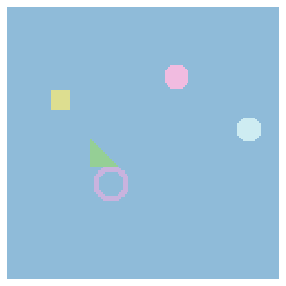

In [5]:
im = open_mask(f'{path_lbl}/img3.png')
# im.data.mul_(50)?
im.show(figsize=(5,5))

In [6]:
codes = np.array(['background', 'triangle', 'circle1', 'circle2', 'square_f', 'plus'])
codes

array(['background', 'triangle', 'circle1', 'circle2', 'square_f', 'plus'], dtype='<U10')

## Datasets

In [7]:
bs=16
size=128
codes = np.array(['background', 'triangle', 'circle1', 'circle2', 'square_f', 'plus'])

get_label_fn = lambda x: f'{path_lbl}/{x.stem}.png'
src = (SegmentationItemList.from_folder(path_img)
       .split_by_rand_pct(valid_pct=0.2, seed=42)
       .label_from_func(get_label_fn, classes=codes))

data = (src.transform(get_transforms(),  tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

In [8]:
data.classes, data.c

(array(['background', 'triangle', 'circle1', 'circle2', 'square_f', 'plus'], dtype='<U10'),
 6)

In [9]:
inputs, labels = next(iter(data.valid_dl))
labels.shape

torch.Size([4, 1, 150, 150])

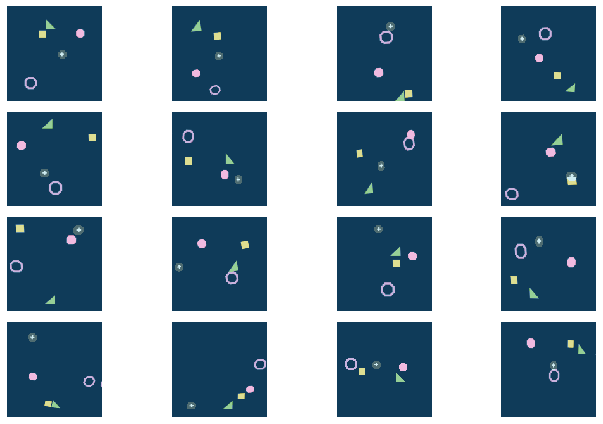

In [10]:
data.show_batch(4, figsize=(10,6))

## Model

In [11]:
name2id = {v:k for k,v in enumerate(codes)}

def acc_metric1(input, target):
    target = target.squeeze(1)
    return (input.argmax(dim=1)==target).float().mean()

def acc_metric2(input, target):
    target = target.squeeze(1)
    return (input.argmax(dim=1)[target>0]==target[target>0]).float().mean()
  

metrics=[acc_metric1, acc_metric2]
wd=1e-2

In [14]:
## Simple Upsample

class StdUpsample(nn.Module):
    def __init__(self, nin, nout):
        super().__init__()
        self.conv = nn.ConvTranspose2d(nin, nout, 2, stride=2)
        self.bn = nn.BatchNorm2d(nout)
        
    def forward(self, x): return self.bn(F.relu(self.conv(x)))
    
flatten_channel = Lambda(lambda x: x[:,0])
unsqeeze_channel = Lambda(lambda x: x.unsqueeze_(1))

class Upsample34(nn.Module):
    def __init__(self, rn):
        super().__init__()
#         self.rn = rn
        self.features = nn.Sequential(
            rn,
            nn.ReLU(),
            StdUpsample(512,256),
            StdUpsample(256,256),
            StdUpsample(256,256),
            StdUpsample(256,256),
            nn.ConvTranspose2d(256, 1, 2, stride=2),
            unsqeeze_channel)   
            
    def forward(self,x): return self.features(x)[:,0]

class UpsampleModel():
    def __init__(self,model,name='upsample'):
        self.model,self.name = model,name

    def get_layer_groups(self, precompute):
        lgs = list(split_by_idxs(children(self.model.rn), [lr_cut]))
        return lgs + [children(self.model.features)[1:]]
  
    
m_base = create_body(models.resnet18)

m = Upsample34(m_base)
mod = UpsampleModel(m)

## uses torch.nn.CrossEntropyLoss(...)    as a super class  
class myLoss2(nn.BCEWithLogitsLoss):    
    def __init__(self, weight=None):
        super(myLoss2, self).__init__()

    def forward(self, input, target):
        target = target.float()
        ret = super(myLoss2, self).forward(input, target)
        return ret
loss_func = myLoss2() 

def acc_camvid(input, target):
#     target = target.float()
        input = (input >0.5).long()
        return (input==target).float().mean()
lr=1e-4
learn = Learner(data, mod.model, loss_func = loss_func, metrics = acc_camvid)
# learn.fit_one_cycle(2, slice(lr), pct_start=0.9)
# learn.freeze_to(1)

In [12]:
def find_modules(m, cond):
    if cond(m): return [m]
    return sum([find_modules(o,cond) for o in m.children()], [])

def is_lin_layer(l):
    lin_layers = (nn.Conv1d, nn.Conv2d, nn.Conv3d, nn.Linear, nn.ReLU)
    return isinstance(l, lin_layers)

### Make unet manual way

In [13]:
# class ResNetUNet(nn.Module):
from torchvision import models

import torch
import torch.nn as nn

base_model = models.resnet18(pretrained=True)
# keep all the layers upto the AdaptiveAvgPool2d layer
cut = next(i for i,o in enumerate(base_model.children()) if isinstance(o,nn.AdaptiveAvgPool2d))
base_model = nn.Sequential(*list(base_model.children())[:cut])

def convrelu(in_channels, out_channels, kernel, padding):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel, padding=padding),
        nn.ReLU(inplace=True),
    )

class ResNetUNet(nn.Module):

    def __init__(self, n_class):
        super().__init__()
        
#         self.base_model = models.resnet18(pretrained=True)
        
        self.base_layers = list(base_model.children())                
        
        self.layer0 = nn.Sequential(*self.base_layers[:3]) # size=(N, 64, x.H/2, x.W/2)
        self.layer0_1x1 = convrelu(64, 64, 1, 0)
        self.layer1 = nn.Sequential(*self.base_layers[3:5]) # size=(N, 64, x.H/4, x.W/4)        
        self.layer1_1x1 = convrelu(64, 64, 1, 0)       
        self.layer2 = self.base_layers[5]  # size=(N, 128, x.H/8, x.W/8)        
        self.layer2_1x1 = convrelu(128, 128, 1, 0)  
        self.layer3 = self.base_layers[6]  # size=(N, 256, x.H/16, x.W/16)        
        self.layer3_1x1 = convrelu(256, 256, 1, 0)  
        self.layer4 = self.base_layers[7]  # size=(N, 512, x.H/32, x.W/32)
        self.layer4_1x1 = convrelu(512, 512, 1, 0)  
        
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        
        self.conv_up3 = convrelu(256 + 512, 512, 3, 1)
        self.conv_up2 = convrelu(128 + 512, 256, 3, 1)
        self.conv_up1 = convrelu(64 + 256, 256, 3, 1)
        self.conv_up0 = convrelu(64 + 256, 128, 3, 1)
        
        self.conv_original_size0 = convrelu(3, 64, 3, 1)
        self.conv_original_size1 = convrelu(64, 64, 3, 1)
        self.conv_original_size2 = convrelu(64 + 128, 64, 3, 1)
        
        self.conv_last = nn.Conv2d(64, n_class, 1)
        
    def forward(self, input):
        x_original = self.conv_original_size0(input)
        x_original = self.conv_original_size1(x_original)
        
        layer0 = self.layer0(input)            
        layer1 = self.layer1(layer0)
        layer2 = self.layer2(layer1)
        layer3 = self.layer3(layer2)        
        layer4 = self.layer4(layer3)
        
        layer4 = self.layer4_1x1(layer4)
        x = self.upsample(layer4)
        layer3 = self.layer3_1x1(layer3)
        x = torch.cat([x, layer3], dim=1)
        x = self.conv_up3(x)
 
        x = self.upsample(x)
        layer2 = self.layer2_1x1(layer2)
        x = torch.cat([x, layer2], dim=1)
        x = self.conv_up2(x)

        x = self.upsample(x)
        layer1 = self.layer1_1x1(layer1)
        x = torch.cat([x, layer1], dim=1)
        x = self.conv_up1(x)

        x = self.upsample(x)
        layer0 = self.layer0_1x1(layer0)
        x = torch.cat([x, layer0], dim=1)
        x = self.conv_up0(x)
        
        x = self.upsample(x)
        x = torch.cat([x, x_original], dim=1)
        x = self.conv_original_size2(x)        
        
        out = self.conv_last(x)        
        
        return out
    
m = ResNetUNet(6).cuda()
# summary(m, (3, 224, 224))

RuntimeError: cuda runtime error (30) : unknown error at /pytorch/aten/src/THC/THCGeneral.cpp:51

In [14]:
 def find_modules(m, cond):
    if cond(m): return [m]
    return sum([find_modules(o,cond) for o in m.children()], [])

def is_lin_layer(l):
    lin_layers = (nn.Conv1d, nn.Conv2d, nn.Conv3d, nn.Linear, nn.ReLU)
    return isinstance(l, lin_layers)
def is_conv_layer(l):
    layers = (nn.Conv1d, nn.Conv2d, nn.Conv3d, nn.MaxPool2d, nn.AvgPool2d)
    return isinstance(l, layers)

list(m.children())
find_modules(m, is_conv_layer)

# base_model = models.resnet18(pretrained=True)
# find_modules(base_model, is_conv_layer)


[Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False),
 Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1)),
 MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False),
 Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
 Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
 Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
 Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
 Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1)),
 Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False),
 Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
 Conv2d(64, 128, kernel_size=(1, 1), stride=(2, 2), bias=False),
 Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
 Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
 Conv2d(128, 128, kernel_siz

In [15]:
summary(base_model.cuda(), (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

### Make UNet  model programatically

In [19]:
from torchvision import models

import torch
import torch.nn as nn

class UnetBlock(nn.Module):
    def __init__(self, up_in, x_in, n_out):
        super().__init__()
        up_out = x_out = n_out//2
        self.x_conv  = nn.Conv2d(x_in,  x_out,  1)
        self.tr_conv = nn.ConvTranspose2d(up_in, up_out, 2, stride=2)
        self.bn = nn.BatchNorm2d(n_out)
        
    def forward(self, up_p, x_p):
        up_p = self.tr_conv(up_p)
        x_p = self.x_conv(x_p)
        cat_p = torch.cat([up_p,x_p], dim=1)
        return self.bn(F.relu(cat_p))
    
class SaveFeatures():
    features=None
    def __init__(self, m): self.hook = m.register_forward_hook(self.hook_fn)
    def hook_fn(self, module, input, output): self.features = output
    def remove(self): self.hook.remove()

class Unet(nn.Module):
    def __init__(self, base_model):
        super().__init__()
        self.base_layers = base_model
        
        self.sfs = [SaveFeatures(base_model[i]) for i in [2,4,5,6]]
        #                   up_in, x_in, n_out, up_out=x_out, size           
        self.up1 = UnetBlock(512,   256,  256) #    128        7
        self.up2 = UnetBlock(256,   128,  256) #    128       28
        self.up3 = UnetBlock(256,   64,   256) #    128       56
        self.up4 = UnetBlock(256,   64,   256) #    128      112
        self.up5 = nn.ConvTranspose2d(256, 6, 2, stride=2)#  224
#         self.conv_last = nn.Conv2d(64, n_class, 1)

        
    def forward(self,x):
        x = F.relu(self.base_layers(x))
#         import pdb; pdb.set_trace()
        x = self.up1(x, self.sfs[3].features)
        x = self.up2(x, self.sfs[2].features)
        x = self.up3(x, self.sfs[1].features)
        x = self.up4(x, self.sfs[0].features)
        x = self.up5(x)
#         import pdb; pdb.set_trace()
#         return x[:,0]
        return x
    
    def close(self):
        for sf in self.sfs: sf.remove()

class UnetModel():
    def __init__(self,model,name='unet'):
        self.model,self.name = model,name

    def get_layer_groups(self, precompute):
        lgs = list(split_by_idxs(children(self.model.rn), [lr_cut]))
        return lgs + [children(self.model)[1:]]
    


def get_base(base_model):
#     base_model = models.resnet18(pretrained=True)
    # keep all the layers upto the AdaptiveAvgPool2d layer
    cut = next(i for i,o in enumerate(base_model.children()) if isinstance(o,nn.AdaptiveAvgPool2d))
    return nn.Sequential(*list(base_model.children())[:cut])

# f = resnet34
# cut,lr_cut = model_meta[f]
# def get_base():
#     layers = cut_model(f(True), cut)
#     return nn.Sequential(*layers) 

m_base = get_base(models.resnet34(pretrained=True))
m = Unet(m_base).cuda()

def run():
    # model = UnetModel(m)
#     import pdb; pdb.set_trace()
    summary(m, (3, size, size))

run()

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 64, 64]           9,408
       BatchNorm2d-2           [-1, 64, 64, 64]             128
              ReLU-3           [-1, 64, 64, 64]               0
         MaxPool2d-4           [-1, 64, 32, 32]               0
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
              ReLU-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
             ReLU-10           [-1, 64, 32, 32]               0
       BasicBlock-11           [-1, 64, 32, 32]               0
           Conv2d-12           [-1, 64, 32, 32]          36,864
      BatchNorm2d-13           [-1, 64, 32, 32]             128
             ReLU-14           [-1, 64,

In [20]:
base_model

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, ker

In [21]:
base_model = m_base = get_base(models.resnet18(pretrained=True))

for i in [2,4,5,6]:
    print("+++++++++++++++++++")
    print(base_model[i])

+++++++++++++++++++
ReLU(inplace=True)
+++++++++++++++++++
Sequential(
  (0): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (1): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
)
+++++++++++++++++++
Sequential(
  (0): BasicBlock(
    (conv1): Conv2d(64, 128, kernel_size

In [21]:
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")
# print(device)
if False:
    model = ResNetUNet(6)
else:
    m_base = get_base(models.resnet18(pretrained=True))
    model = Unet(m_base)

# freeze backbone layers
# Comment out to finetune further
for l in model.base_layers:
    for param in l.parameters():
        param.requires_grad = False
    
## uses torch.nn.CrossEntropyLoss(...)    as a super class  
# class myLoss2(nn.BCEWithLogitsLoss):    
class myLoss2(nn.CrossEntropyLoss):    
    def __init__(self, weight=None):
        super(myLoss2, self).__init__()

    def forward(self, input, target):
#         import pdb; pdb.set_trace()
        target = target.squeeze()
        ret = super(myLoss2, self).forward(input, target)
        return ret
loss_func = myLoss2() 

def acc_camvid(input, target):
#     target = target.float()
        input = (input >0.5).long()
        return (input==target).float().mean()
lr=1e-4
learn = Learner(data, model, loss_func = loss_func, metrics = metrics)
# learn.fit_one_cycle(2, slice(lr), pct_start=0.9)
# learn.freeze_to(1)
# summary(model, (3, 224, 224))    

In [22]:
# %debug
learn.lr_find()
learn.recorder.plot()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


RuntimeError: invalid argument 0: Sizes of tensors must match except in dimension 1. Got 19 and 20 in dimension 2 at /pytorch/aten/src/THC/generic/THCTensorMath.cu:71

In [15]:
lr=1e-4
learn = Learner(data, model, loss_func = loss_func, metrics = metrics)
learn.fit_one_cycle(10, slice(lr), pct_start=0.9)

NameError: name 'model' is not defined

In [ ]:
learn.show_results()

In [ ]:
data.train_dl

inputs, labels = next(iter(data.train_dl))
inputs = inputs.to(device)
labels = labels.to(device)

pred = learn.model(inputs)
pred = torch.sigmoid(pred)
pred = pred.data.cpu().numpy()
print(pred.shape)

In [ ]:
inputs, labels = next(iter(data.train_dl))
labels.shape

In [ ]:
labels.shape

In [ ]:
# pred = torch.sigmoid(model(inputs)).data.cpu().numpy()
pred = model(inputs).data.cpu().numpy()

pred.max(), pred.min(), pred.shape

In [ ]:
show_img(pred[0,3])


In [ ]:
inputs.shape, inputs.min(), inputs.max(), inputs.mean(), inputs.std()
# Image(inputs[0])

In [ ]:
# img = open_image('data/FEC-half/positive/220972 - 1.jpg').resize(1380)

# img = open_image('data/test/143268 - 2.jpg')
img = PIL.Image.open(f'{path_img}/img3-9.png')

show_img(img)
print(np.asarray(img).max())
# img = PIL.Image.open('data/220972 - 1.jpg')
img = img.resize((128,128), resample=PIL.Image.BILINEAR)
img = Image(pil2tensor(img,np.float32).div_(255))
# img = Image(pil2tensor(img,np.float32))
# img = Image(pil2tensor(img,np.float32))
print(img.px.max())
pc,pi,o = learn.predict(img)  

pc.shape, pi.shape, o.shape, pc.px.max(), pi.max(), o.max()
# pred_class[i] = pc.px

# hstack = [torch.cat(pred_class[y:y+TN],dim=2) for y in range(0,TN*TM,TN)]  
# vstack = torch.cat(hstack,dim=1)
# Image(vstack).show(figsize = (10,10))

In [ ]:
pc

In [ ]:
pi

In [ ]:
pc.px.max(), pi.max(), o.max()

In [ ]:
learn.show_results(rows=3, figsize=(10,20))